In [1]:
import numpy as np
import pandas as pd
import umap ###install with "pip install umap-learn"
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
pd.options.display.max_rows=10
pd.options.display.max_columns=6

In [19]:
class KNN_impute:

    def __init__(self, datafile, IDs = []):
        self.data = pd.read_csv(datafile)
        self.IDs = IDs
        self.IDdf = self.data.filter(IDs)
        self.nonIDdf = pd.DataFrame(self.data.drop(self.IDs, axis=1))

    def scale (self, scaler, csvname):
        self.scaler = scaler
        self.scaled_data = pd.DataFrame(self.scaler.fit_transform(self.data.drop(self.IDs, axis=1)), columns=self.nonIDdf.columns)
        self.combine_dfs = [self.IDdf, self.scaled_data]
        self.scaled_data_with_IDs = pd.concat(self.combine_dfs, axis=1)
        self.scaled_data_with_IDs.to_csv(csvname, index=False)
        
    def impute (self, imputer):
        self.imputer = imputer
        self.imputed_data = self.imputer.fit_transform(self.scaled_data_with_IDs)
        self.output_df = pd.DataFrame(self.imputed_data, columns=self.scaled_data_with_IDs.columns)
        
    def unique_viz (self, csvname, figsize=[]):
        self.unique = pd.DataFrame(self.output_df.drop(self.IDs, axis=1).nunique(axis=0))
        self.unique.columns = ["num_unique"]
        self.unique.index.name = 'feature'
        self.cutpoint_plot = self.unique.plot.line(figsize=figsize)
        self.unique.to_csv(csvname, index=True)
        
    def filterCols (self, cutpoint, csvname):
        self.new_df = self.output_df
        for col in self.output_df.drop(self.IDs, axis=1).columns:
            if len(self.output_df[col].unique()) < cutpoint:
                self.new_df = self.new_df.drop(col,axis=1)
        self.new_df.to_csv(csvname, index=False)
        self.final_df = pd.DataFrame(self.new_df)

#### KNN Imputation of Missing Values in Yaw Data

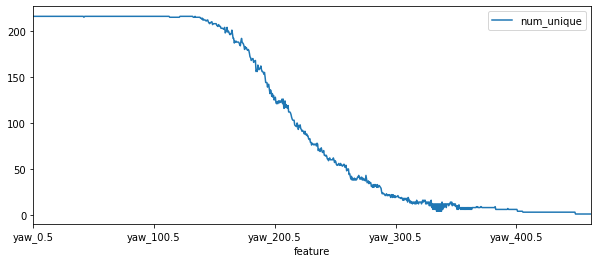

In [22]:
yaw = KNN_impute("Data_Yaw.csv", IDs = ['labvisitid', 'presence'])
yaw.scale(MinMaxScaler(), "yaw_scaled.csv")
yaw.impute(KNNImputer(n_neighbors=3))
yaw_all = pd.DataFrame(yaw.output_df)
yaw.unique_viz("yaw_unique.csv", figsize=(10,4))
yawline = yaw.cutpoint_plot

In [23]:
yaw.filterCols(30, "yaw_imputed.csv")
yaw.final_df

,labvisitid,presence,yaw_0.5,...,yaw_287,yaw_287.5,yaw_288
0,1.0,4.0,0.424407,...,0.289145,0.294373,0.306312
1,2.0,3.2,0.419289,...,0.289145,0.294373,0.306312
2,3.0,3.4,0.476286,...,0.289145,0.294373,0.306312
3,4.0,2.8,0.511884,...,0.289145,0.294373,0.306312
4,5.0,3.4,0.474331,...,0.289145,0.294373,0.306312
...,...,...,...,...,...,...,...
211,259.0,2.8,0.498104,...,0.404961,0.404995,0.420951
212,260.0,3.4,0.526236,...,0.404961,0.404995,0.420951
213,261.0,4.0,0.488090,...,0.404961,0.404995,0.420951
214,262.0,4.8,0.322758,...,0.404961,0.404995,0.420951


#### KNN Imputation of Missing Values in Pitch Data

     labvisitid  presence  pitch_0.5  ...  pitch_461.5  pitch_462  pitch_462.5
0           1.0       4.0   0.548471  ...          0.0        0.0          0.0
1           2.0       3.2   0.288129  ...          0.0        0.0          0.0
2           3.0       3.4   0.139014  ...          0.0        0.0          0.0
3           4.0       2.8   0.659744  ...          0.0        0.0          0.0
4           5.0       3.4   0.087555  ...          0.0        0.0          0.0
..          ...       ...        ...  ...          ...        ...          ...
211       259.0       2.8   0.232430  ...          0.0        0.0          0.0
212       260.0       3.4   0.187118  ...          0.0        0.0          0.0
213       261.0       4.0   0.178444  ...          0.0        0.0          0.0
214       262.0       4.8   0.394587  ...          0.0        0.0          0.0
215       263.0       4.4   0.093992  ...          0.0        0.0          0.0

[216 rows x 927 columns]


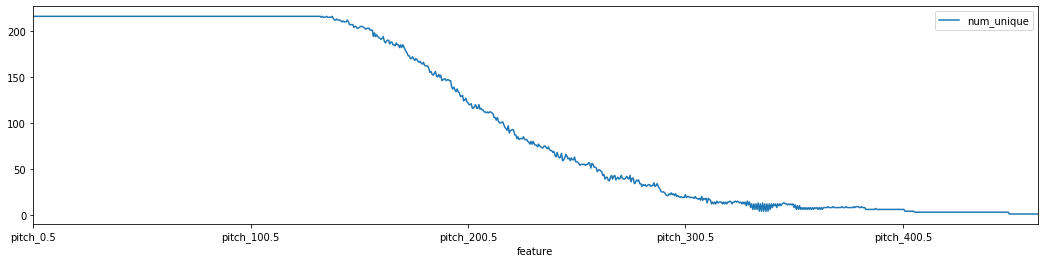

In [6]:
pitch = KNN_impute("Data_Pitch.csv", IDs = ['labvisitid', 'presence'])
pitch.scale(MinMaxScaler(), "pitch_scaled.csv")
pitch.impute(KNNImputer(n_neighbors=3))
pitch_all = pd.DataFrame(pitch.output_df)
print(pitch_all)
pitch.unique_viz("pitch_unique.csv")
pitchline = pitch.cutpoint_plot

In [7]:
pitch.filterCols(30, "pitch_imputed.csv")

#### KNN Imputation of Missing Values in Roll Data

     labvisitid  presence  roll_0.5  ...  roll_461.5  roll_462  roll_462.5
0           1.0       4.0  0.654311  ...         0.0       0.0         0.0
1           2.0       3.2  0.379595  ...         0.0       0.0         0.0
2           3.0       3.4  0.468124  ...         0.0       0.0         0.0
3           4.0       2.8  0.522523  ...         0.0       0.0         0.0
4           5.0       3.4  0.468145  ...         0.0       0.0         0.0
..          ...       ...       ...  ...         ...       ...         ...
211       259.0       2.8  0.660400  ...         0.0       0.0         0.0
212       260.0       3.4  0.563272  ...         0.0       0.0         0.0
213       261.0       4.0  0.625336  ...         0.0       0.0         0.0
214       262.0       4.8  0.545936  ...         0.0       0.0         0.0
215       263.0       4.4  0.489715  ...         0.0       0.0         0.0

[216 rows x 927 columns]


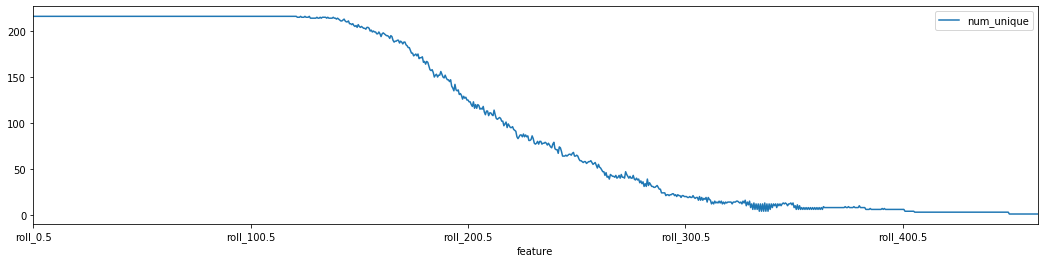

In [8]:
roll = KNN_impute("Data_Roll.csv", IDs = ['labvisitid', 'presence'])
roll.scale(MinMaxScaler(), "roll_scaled.csv")
roll.impute(KNNImputer(n_neighbors=3))
roll_all = pd.DataFrame(roll.output_df)
print(roll_all)
roll.unique_viz("roll_unique.csv")
rollline = roll.cutpoint_plot

In [9]:
roll.filterCols(30, "roll_imputed.csv")

#### KNN Imputation of Missing Values in X-Axis Data

     labvisitid  presence     x_0.5  ...  x_461.5  x_462  x_462.5
0           1.0       4.0  0.263141  ...      0.0    0.0      0.0
1           2.0       3.2  0.405601  ...      0.0    0.0      0.0
2           3.0       3.4  0.351221  ...      0.0    0.0      0.0
3           4.0       2.8  0.285647  ...      0.0    0.0      0.0
4           5.0       3.4  0.404023  ...      0.0    0.0      0.0
..          ...       ...       ...  ...      ...    ...      ...
211       259.0       2.8  0.249609  ...      0.0    0.0      0.0
212       260.0       3.4  0.185196  ...      0.0    0.0      0.0
213       261.0       4.0  0.446995  ...      0.0    0.0      0.0
214       262.0       4.8  0.106594  ...      0.0    0.0      0.0
215       263.0       4.4  0.354316  ...      0.0    0.0      0.0

[216 rows x 927 columns]


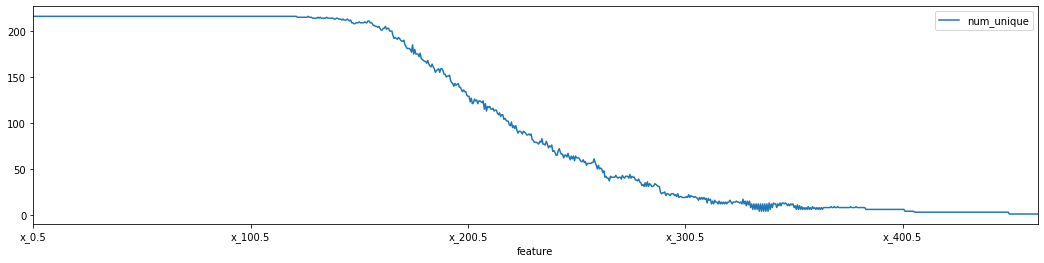

In [10]:
x = KNN_impute("Data_X.csv", IDs = ['labvisitid', 'presence'])
x.scale(MinMaxScaler(), "x_scaled.csv")
x.impute(KNNImputer(n_neighbors=3))
x_all = pd.DataFrame(x.output_df)
print(x_all)
x.unique_viz("x_unique.csv")
xline = x.cutpoint_plot

In [11]:
x.filterCols(30, "x_imputed.csv")

#### KNN Imputation of Missing Values in Y-Axis Data

     labvisitid  presence     y_0.5  ...  y_461.5  y_462  y_462.5
0           1.0       4.0  0.428549  ...      0.0    0.0      0.0
1           2.0       3.2  0.537047  ...      0.0    0.0      0.0
2           3.0       3.4  0.557278  ...      0.0    0.0      0.0
3           4.0       2.8  0.342932  ...      0.0    0.0      0.0
4           5.0       3.4  0.548548  ...      0.0    0.0      0.0
..          ...       ...       ...  ...      ...    ...      ...
211       259.0       2.8  0.316860  ...      0.0    0.0      0.0
212       260.0       3.4  0.454712  ...      0.0    0.0      0.0
213       261.0       4.0  0.910611  ...      0.0    0.0      0.0
214       262.0       4.8  0.428715  ...      0.0    0.0      0.0
215       263.0       4.4  0.366374  ...      0.0    0.0      0.0

[216 rows x 927 columns]


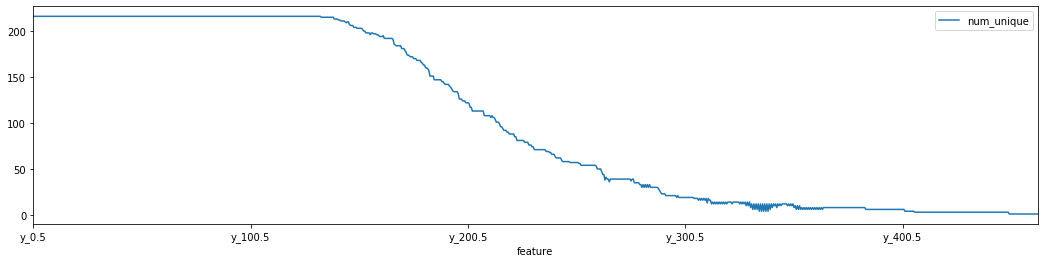

In [13]:
y = KNN_impute("Data_Y.csv", IDs = ['labvisitid', 'presence'])
y.scale(MinMaxScaler(), "y_scaled.csv")
y.impute(KNNImputer(n_neighbors=3))
y_all = pd.DataFrame(y.output_df)
print(y_all)
y.unique_viz("y_unique.csv")
yline = y.cutpoint_plot

In [14]:
y.filterCols(30, "y_imputed.csv")

#### KNN Imputation of Missing Values in Z-Axis Data

     labvisitid  presence     z_0.5  ...  z_461.5  z_462  z_462.5
0           1.0       4.0  0.149444  ...      0.0    0.0      0.0
1           2.0       3.2  0.119485  ...      0.0    0.0      0.0
2           3.0       3.4  0.112860  ...      0.0    0.0      0.0
3           4.0       2.8  0.315297  ...      0.0    0.0      0.0
4           5.0       3.4  0.200984  ...      0.0    0.0      0.0
..          ...       ...       ...  ...      ...    ...      ...
211       259.0       2.8  0.243777  ...      0.0    0.0      0.0
212       260.0       3.4  0.155403  ...      0.0    0.0      0.0
213       261.0       4.0  0.164612  ...      0.0    0.0      0.0
214       262.0       4.8  0.177309  ...      0.0    0.0      0.0
215       263.0       4.4  0.227917  ...      0.0    0.0      0.0

[216 rows x 927 columns]


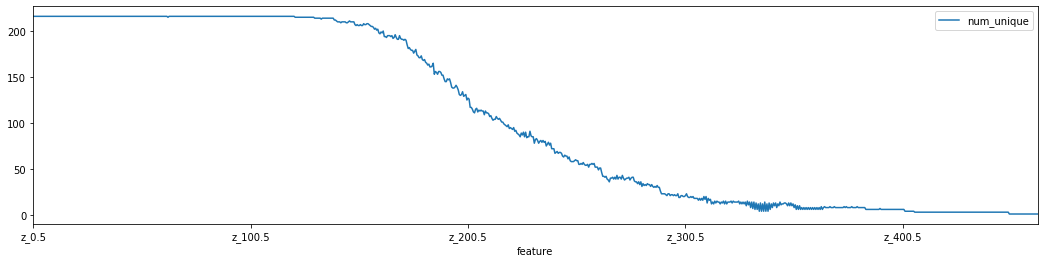

In [16]:
z = KNN_impute("Data_Z.csv", IDs = ['labvisitid', 'presence'])
z.scale(MinMaxScaler(), "z_scaled.csv")
z.impute(KNNImputer(n_neighbors=3))
z_all = pd.DataFrame(z.output_df)
print(z_all)
z.unique_viz("z_unique.csv")
zline = z.cutpoint_plot

In [17]:
z.filterCols(30, "z_imputed.csv")

### Concatenating Data from All Six DataFrames

In [18]:
imputed_dfs = [yaw.final_df, pitch.final_df, roll.final_df, x.final_df, y.final_df, z.final_df]
imputed_data = pd.concat(imputed_dfs, axis=1)
imputed_data = imputed_data.loc[:,~imputed_data.columns.duplicated()]
imputed_data.to_csv("SCALED_NONAN_DATA.csv", index=False)